# FraudDetect

**Modelo con redes neuronales**

Cuaderno que recoge el proceso de desarrollo del modelo para la aplicación FraudDetect de Pablo Oller, Pablo Santos y Alejandro Castillo.

## Definición de objetivo y de campos

El objetivo de nuestro proyecto es detectar actividades fraudulentas de transacciones bancarias. Para ello vamos a entrenar un modelo cuya funcionalidad será detectar si los movimientos que le pasemos son fraudulentos o no.

Además de eso vamos a entrenar un modelo de clusterización para detectar que tipo de gastos son esos movimientos.

Análisis de columnas:

* **Time:** Tiempo en segundos que pasó desde la anterior transacción del dataset
* **V1 - V28:** Datos de un PCA sometidos a una reducción para proteger la información personal de los clientes de la entidad bancaria
* **Amount:** Cantidad de la transacción
* **Class:** 1 es fraude y 0 es no fraude

## Importaciones de librerías necesarias

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from joblib import dump

In [5]:
# Versión de TensorFlow
print(tf.__version__)

2.15.0


In [6]:
# Lectura del fichero. llamo a nuestro dataframe ccdf (credit card dataframe)
ccdf = pd.read_csv('/content/creditcard.csv')

## Exploración, visualización y tratamiento de los datos

In [7]:
ccdf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Observamos las dimensiones de nuestro DataFrame
ccdf.shape

(284807, 31)

In [9]:
# Ahora vamos a detectar los valores nulos que pueda haber
ccdf.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
ccdf.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
# Hay valores nulos así que los vamos a eliminar quitando las filas que los alberguen
ccdf.dropna(subset=["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10",
                    "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19",
                    "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"],
            inplace=True)

In [12]:
# Volvemos a observar si queda algún valor nulo entre nuestros datos
ccdf.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [13]:
# observamos la información general de nuestro Dataset y podemos observar que todos los datos son de tipo float
ccdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
ccdf['V22'] = ccdf['V22'].astype(float)

In [15]:
# Vemos cuantos valores son transacciones legítimas y cuantas fraudulentas
ccdf['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Equilibración del Dataset

Ahora hacemos un balanceo de datos para ajustar la distribución de las clases y poder representarla de la misma manera.

Esto lo hacemos porque en nuestro Dataset encontramos un desequilibrio muy notable entre los casos de fraude y los casos de no fraude. Este tipo de desequilibrio puede sesgar el rendimiento de nuestro modelo de detección de fraude ya que suelen favorecer a la clase que más valores tienen.

In [16]:
legit = ccdf[ccdf['Class']==0]
fraud = ccdf[ccdf['Class']==1]

In [17]:
legit.shape

(284315, 31)

In [18]:
fraud.shape

(492, 31)

In [19]:
legit = legit.sample(fraud.shape[0])
legit.shape

(492, 31)

In [20]:
ccdf['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Mapa de Calor

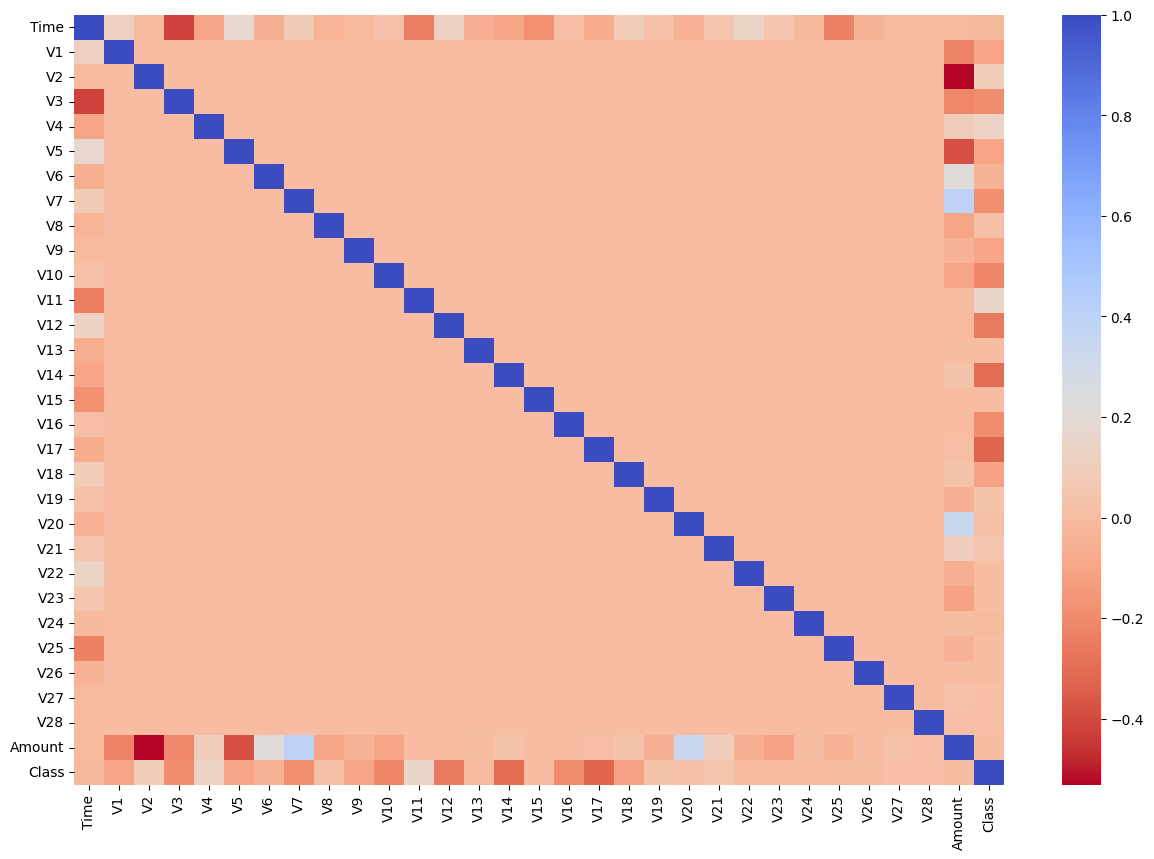

In [21]:
# Mapa de calor para observar la correlaciones de los datos
f, (ax) = plt.subplots(1, figsize=(15,10))
sub_sample_corr = ccdf.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r')
plt.show()

## Outliers

Vamos a borrar los outliers de los atributos de nuestro Dataframe. Esto beneficiará a la precisión de nuestro modelo.

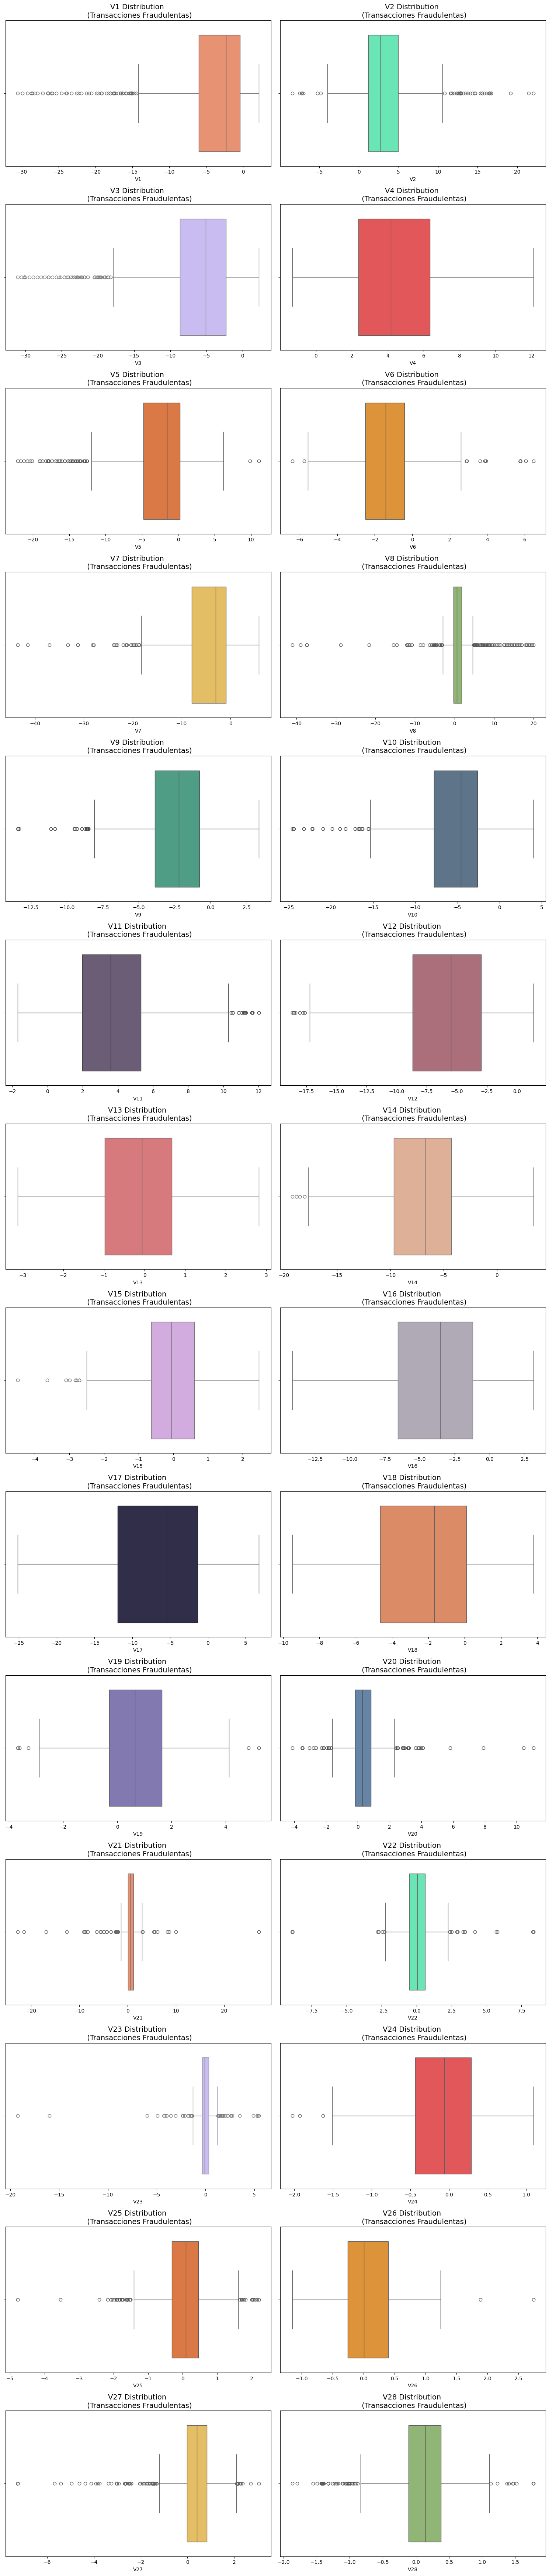

In [22]:
# Lista de colores
colores = ['#FB8861', '#56F9BB', '#C5B3F9', '#F94144', '#F3722C', '#F8961E',
           '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A', '#B56576',
           '#E56B6F', '#EAAC8B', '#D6A2E8', '#B0A8B9', '#2E294E', '#EF8354',
           '#7D70BA', '#5B84B1', '#FB8861', '#56F9BB', '#C5B3F9', '#F94144',
           '#F3722C', '#F8961E', '#F9C74F', '#90BE6D', '#43AA8B', '#577590']

# Subplots
fig, axs = plt.subplots(14, 2, figsize=(15, 70))

# Bucle para crear las gráficas tipo boxplot para poder observar los outliers de todas las columnas
for i in range(1, 29):
    fraud_dist = ccdf['V'+str(i)].loc[ccdf['Class'] == 1]
    ax = axs[(i-1)//2, (i-1)%2]

    sns.boxplot(x=fraud_dist, color=colores[i-1], ax=ax)
    ax.set_title('V'+str(i)+' Distribution \n (Transacciones Fraudulentas)', fontsize=14)

plt.tight_layout()
plt.show()

Aquí tenemos el código que se encarga de eliminar los outliers.

Observamos en él los límites del rango intercuartil (IQR), se calcula el propio rango (la diferencia entre el percentil 75 y el percentil 25), el valor de corte (1.5 veces el IQR) y los límites inferiores y superiores para determinar los valores atípicos.

Cualquier valor que sea mayor la límite superior o menor que el límite inferior serán añadidos a una lista de valores para cada columna. Después se eliminirán esos valores atípicos y se muestran todos los cálculos.

In [23]:
columnas = ['V'+str(i) for i in range(1, 29)]

# Bucle que se encarga de eliminar los outliers de todas las columnas.
for columna in columnas:
    v_fraud = ccdf[columna].loc[ccdf['Class'] == 1].values
    q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    v_iqr = q75 - q25
    print('iqr: {}'.format(v_iqr))

    v_cut_off = v_iqr * 1.5
    v_lower, v_upper = q25 - v_cut_off, q75 + v_cut_off
    print('Cut Off: {}'.format(v_cut_off))
    print(columna+' Lower: {}'.format(v_lower))
    print(columna+' Upper: {}'.format(v_upper))

    outliers = [x for x in v_fraud if x < v_lower or x > v_upper]
    print('Atributo '+columna+' Outliers para Casos de Fraude: {}'.format(len(outliers)))
    print(columna+' outliers:{}'.format(outliers))

    ccdf = ccdf.drop(ccdf[(ccdf[columna] > v_upper) | (ccdf[columna] < v_lower)].index)
    print('Numero de ocurrencias despúes de eliminar outliers: {}'.format(len(ccdf)))
    print('-' * 333)


Quartile 25: -6.03606299434868 | Quartile 75: -0.419200076257679
iqr: 5.616862918091001
Cut Off: 8.4252943771365
V1 Lower: -14.461357371485182
V1 Upper: 8.006094300878821
Atributo V1 Outliers para Casos de Fraude: 52
V1 outliers:[-14.4744374924863, -15.3988450085358, -14.7246270119253, -15.2713618637585, -15.8191787207718, -16.3679230107968, -16.9174682656955, -17.4677100117887, -18.0185611876771, -15.9036352020113, -16.5986647432584, -17.2751911945397, -18.474867903441, -19.1798264145873, -19.8563223334433, -20.5327510764355, -21.2091195927913, -21.8854339051741, -22.5616992591298, -23.237920244511, -23.9141008948243, -24.5902447690465, -25.2663550194138, -25.9424344479142, -27.1436784229495, -27.84818067198, -28.5242675938406, -29.2003285905744, -29.8763655139763, -30.552380043581, -15.0209806030789, -14.9703456545046, -15.1404496225073, -16.5265065691231, -18.2475132286673, -19.1397328634111, -20.9069081014654, -26.4577446501446, -26.4577446501446, -26.4577446501446, -26.45774465014

Volvemos a visualizar las gráficas anteriores para apreciar todos los outliers que han sido eliminados de nuestro Dataframe.

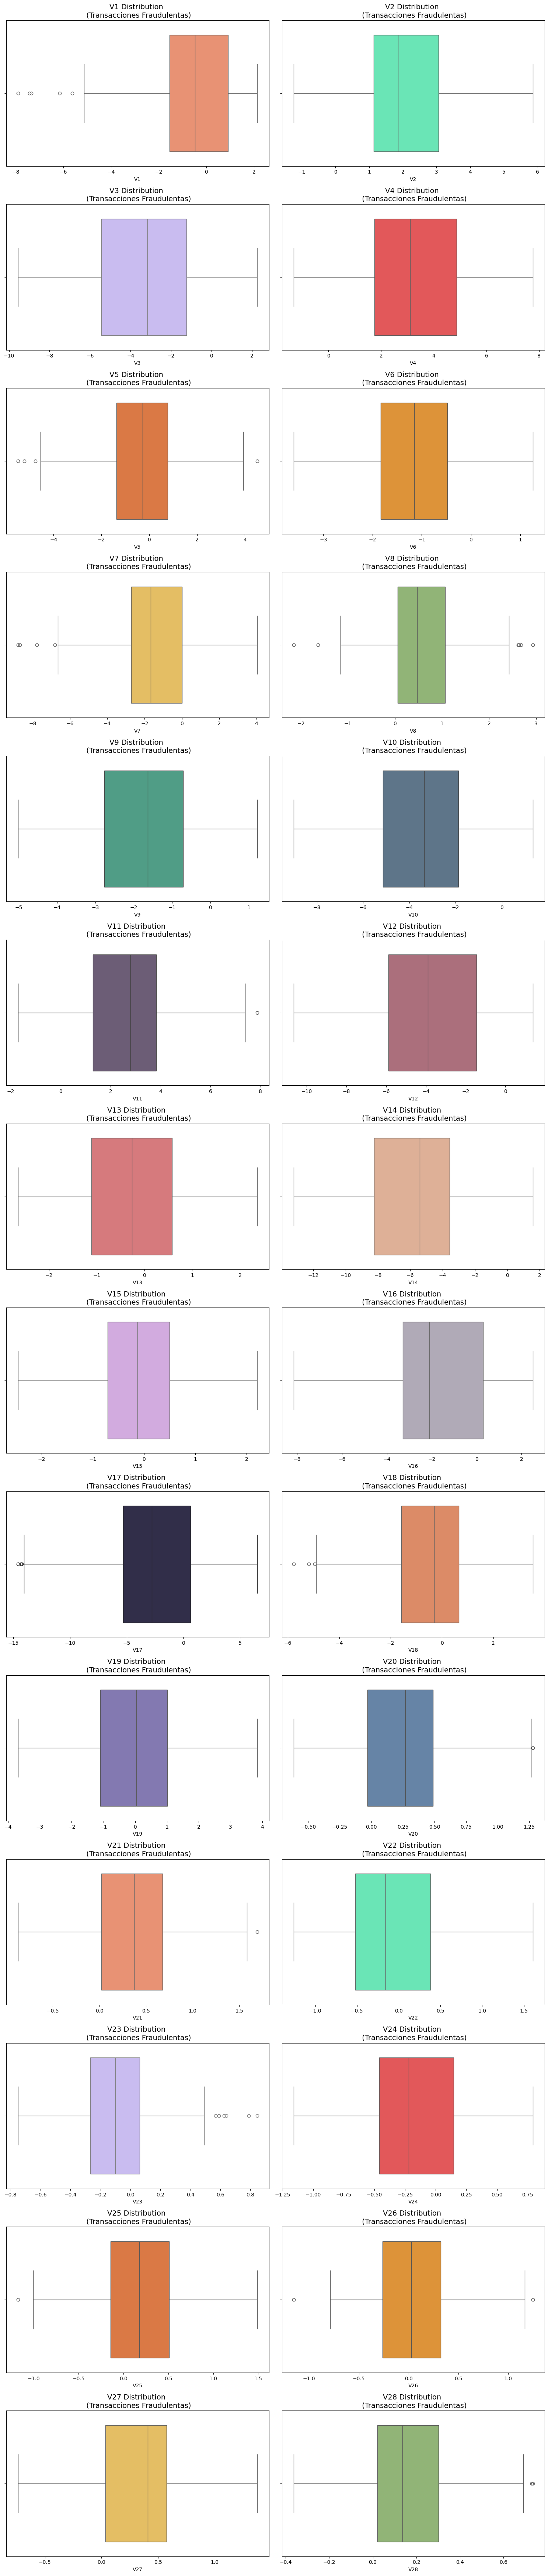

In [24]:
colores = ['#FB8861', '#56F9BB', '#C5B3F9', '#F94144', '#F3722C', '#F8961E',
           '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A', '#B56576',
           '#E56B6F', '#EAAC8B', '#D6A2E8', '#B0A8B9', '#2E294E', '#EF8354',
           '#7D70BA', '#5B84B1', '#FB8861', '#56F9BB', '#C5B3F9', '#F94144',
           '#F3722C', '#F8961E', '#F9C74F', '#90BE6D', '#43AA8B', '#577590']

fig, axs = plt.subplots(14, 2, figsize=(15, 70))

for i in range(1, 29):
    fraud_dist = ccdf['V'+str(i)].loc[ccdf['Class'] == 1]
    ax = axs[(i-1)//2, (i-1)%2]

    sns.boxplot(x=fraud_dist, color=colores[i-1], ax=ax)
    ax.set_title('V'+str(i)+' Distribution \n (Transacciones Fraudulentas)', fontsize=14)

plt.tight_layout()
plt.show()

## Entrenamiento del modelo

In [25]:
# Separación del Dataset
X = ccdf.drop('Class', axis=1)
y = ccdf['Class']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # random_state=0, stratify=y

In [27]:
X_train.shape, X_test.shape

((173954, 30), (43489, 30))

In [28]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
222411,142958.0,0.020464,0.818555,0.279477,-0.584819,0.408652,-1.040915,0.999048,-0.170935,-0.015439,...,-0.043752,-0.253012,-0.566007,0.094321,-0.026702,-0.508767,0.143942,0.246630,0.096975,9.12
270697,164214.0,2.032776,-0.046887,-1.638821,0.190064,0.487661,-0.760755,0.453853,-0.388572,0.184986,...,-0.035070,-0.109556,-0.193149,0.175062,0.682928,0.004142,0.487003,-0.095546,-0.057309,37.40
190219,128742.0,1.881721,0.201252,-0.180083,4.063509,-0.149050,0.220180,-0.301868,0.135565,0.007213,...,-0.442254,0.069212,0.420141,0.108200,-0.052050,0.032289,0.143460,-0.010377,-0.051382,0.00
119408,75436.0,1.425046,-1.218294,0.810875,-1.402967,-1.710466,-0.378956,-1.284834,-0.114953,-1.604712,...,-0.137464,-0.140823,-0.070410,-0.025977,-0.114426,0.249582,-0.203582,0.060090,0.039315,60.76
235606,148463.0,-1.581499,0.638395,0.846586,-0.947238,0.385599,1.483249,-0.373364,1.074824,0.263211,...,-0.128762,0.317302,1.266533,-0.024897,-1.356515,-0.179048,0.737884,0.285691,0.148608,18.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103135,68511.0,1.516687,-0.845753,0.046412,-1.386594,-1.063895,-0.754491,-0.684266,-0.232328,-2.109041,...,-0.368757,-0.179636,-0.052079,0.004880,0.081614,0.500031,-0.115809,0.028928,0.008052,5.95
229985,146136.0,0.198478,1.067829,-1.376403,-0.137531,0.538238,-1.026212,0.673739,0.143978,-0.110503,...,-0.159542,0.293257,0.793921,-0.106425,-0.739788,-0.168317,-0.109636,-0.079403,-0.049477,40.00
195964,131300.0,1.638909,-0.806851,-2.156133,0.528729,0.255631,-0.814970,0.759806,-0.387330,0.403601,...,0.234061,0.131816,-0.001946,-0.127040,0.711650,0.145811,0.557569,-0.151534,-0.033038,244.10
192446,129696.0,2.012953,-0.046077,-0.791219,0.303813,-0.394603,-0.920728,-0.377496,-0.138524,1.185685,...,-0.138487,-0.266462,-0.556032,0.347921,-0.223123,-0.455669,-0.277996,0.029752,-0.009965,0.77


In [29]:
ccdf = fraud.append(legit, ignore_index=True)
ccdf

<ipython-input-29-a77b467d3479>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ccdf = fraud.append(legit, ignore_index=True)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,83649.0,-0.416094,0.946972,1.535867,-0.017599,-0.197070,-0.927376,0.621247,0.008576,-0.194193,...,-0.242339,-0.703787,-0.002073,0.329566,-0.238724,0.075579,0.256035,0.118243,4.49,0
980,144298.0,-0.314848,-0.491023,0.043379,-1.172094,2.630379,3.970517,-0.498038,0.933081,0.573519,...,0.302286,0.976457,0.028608,0.753327,-0.691489,0.201007,0.063510,-0.008396,44.22,0
981,55086.0,1.073135,-1.304944,1.046033,-0.468642,-1.497430,0.678596,-1.082262,0.314917,0.125745,...,-0.742540,-1.408882,0.159184,0.079570,-0.107194,1.197509,-0.031223,0.010779,90.00,0
982,43757.0,1.333519,-1.091836,0.322732,-1.434698,-1.313434,-0.512193,-0.803751,-0.018318,-2.280847,...,-0.529190,-1.356493,0.296495,0.120024,-0.076515,-0.645358,0.018647,0.020566,62.01,0


Observamos que las escalas de los datos son muy diferentes las unas de las otras. Por ello vamos a estandarizar los datos.

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Transformación del target a un array de Numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Ahora unas pequeñas transformaciones y ya podemos empezar a probar algoritmos.

In [32]:
X_train.shape

(173954, 30)

In [33]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [34]:
X_train.shape, X_test.shape

((173954, 30, 1), (43489, 30, 1))

## Red Neuronal

### Añadiendo MaxPool

In [35]:
def plot_learning_curve(history, epoch):
  # Entrenamiento & valores de validation accuracy
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Precisión del modelo')
  plt.ylabel('Precisión')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Entrenamiento & valores de validation loss
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Loss del modelo')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

Aquí mostramos el por qué no utilizamos capas MaxPool. En nuestro caso hace decrecer la optimización del modelo. No se aprecia demasiado, pero es contraproducente.

In [36]:
epochs = 15
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2)) # Aquí
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2)) # Aquí
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,  epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
5437/5437 [==============================] - 34s 6ms/step - loss: 0.0496 - accuracy: 0.9867 - val_loss: 0.0052 - val_accuracy: 0.9995
Epoch 2/15
5437/5437 [==============================] - 31s 6ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch 3/15
5437/5437 [==============================] - 32s 6ms/step - loss: 0.0052 - accuracy: 0.9993 - val_loss: 0.0048 - val_accuracy: 0.9995
Epoch 4/15
5437/5437 [==============================] - 30s 6ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.0058 - val_accuracy: 0.9995
Epoch 5/15
5437/5437 [==============================] - 31s 6ms/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0044 - val_accuracy: 0.9995
Epoch 6/15
5437/5437 [==============================] - 33s 6ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.0044 - val_accuracy: 0.9995
Epoch 7/15
5437/5437 [==============================] - 31s 6ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0042 - val_ac

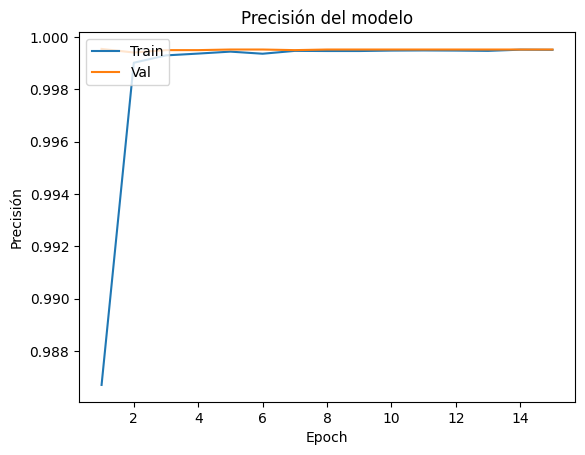

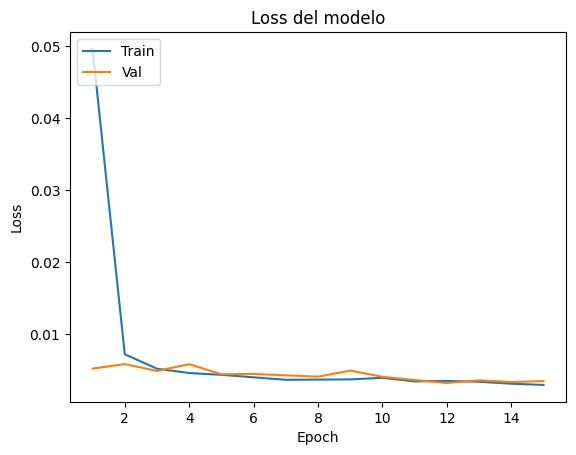

In [37]:
plot_learning_curve(history, epochs)

### Sin añadir MaxPool

In [38]:
epochs = 15
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 32)            96        
                                                                 
 batch_normalization_2 (Bat  (None, 29, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 29, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 batch_normalization_3 (Bat  (None, 28, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 28, 64)           

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, y_train,  epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
5437/5437 [==============================] - 49s 9ms/step - loss: 0.0584 - accuracy: 0.9787 - val_loss: 0.0044 - val_accuracy: 0.9995
Epoch 2/15
5437/5437 [==============================] - 50s 9ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.0036 - val_accuracy: 0.9996
Epoch 3/15
5437/5437 [==============================] - 52s 10ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.0038 - val_accuracy: 0.9996
Epoch 4/15
5437/5437 [==============================] - 53s 10ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 5/15
5437/5437 [==============================] - 53s 10ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9996
Epoch 6/15
5437/5437 [==============================] - 51s 9ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 0.9996
Epoch 7/15
5437/5437 [==============================] - 51s 9ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0034 - val

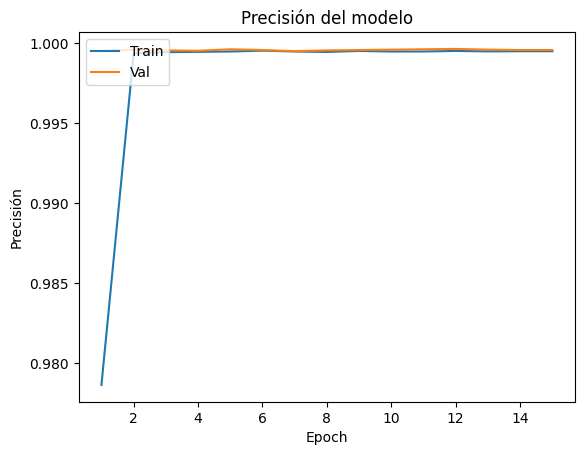

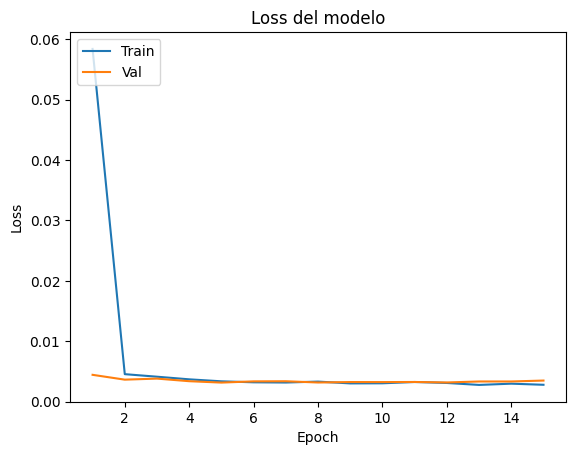

In [42]:
plot_learning_curve(history, epochs)

## Modelo de Clustering

Queríamos añadir la capacidad de clasificar las transacciones en diferentes agrupaciones. Por ello vamos a entrenar un modelo de Clustering.

### Preprocesamiento del dataset

Ya hemos limpiado el dataset con anterioridad así que no es necesario volver a hacerlo. También recalcar que los datos ya están estandarizados.

De todas formas vamos a tener que tocar un poco el Dataframe mediante combinaciones de atributos para tener unas agrupaciones lógicas.

In [43]:
ccdf['Median'] = ccdf[["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10",
                       "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19",
                       "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"]].mean(axis=1)

In [44]:
ccdf

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Median
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,-0.484571
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,0.148612
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,-0.755080
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,-1.866638
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,0.194415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,83649.0,-0.416094,0.946972,1.535867,-0.017599,-0.197070,-0.927376,0.621247,0.008576,-0.194193,...,-0.703787,-0.002073,0.329566,-0.238724,0.075579,0.256035,0.118243,4.49,0,-0.029101
980,144298.0,-0.314848,-0.491023,0.043379,-1.172094,2.630379,3.970517,-0.498038,0.933081,0.573519,...,0.976457,0.028608,0.753327,-0.691489,0.201007,0.063510,-0.008396,44.22,0,0.286308
981,55086.0,1.073135,-1.304944,1.046033,-0.468642,-1.497430,0.678596,-1.082262,0.314917,0.125745,...,-1.408882,0.159184,0.079570,-0.107194,1.197509,-0.031223,0.010779,90.00,0,-0.140589
982,43757.0,1.333519,-1.091836,0.322732,-1.434698,-1.313434,-0.512193,-0.803751,-0.018318,-2.280847,...,-1.356493,0.296495,0.120024,-0.076515,-0.645358,0.018647,0.020566,62.01,0,-0.198718


### Agrupación idónea

Hay muchas formas de identificar el número óptimo de clusteres, nosotros nos hemos decantado por el metodo de Elbow que nos muestra una medida de como de bien ha agrupado el algoritmo de K-Means los clusters.

Ahora vamos a mostrar una gráfica en la que podamos apreciar el punto en el que ese valor empieza a ser idóneo.

In [45]:
# Función para buscar el número óptimo de clusters
def optimizacion_cluster(data, max_clstr):
  means = []
  inertias = []

  for i in range(1, max_clstr):
    kmeans= KMeans(n_clusters=i, n_init=10)
    kmeans.fit(data)

    means.append(i)
    inertias.append(kmeans.inertia_)

  # Generación de la gráfica
  fig = plt.subplots(figsize=(10, 5))
  plt.plot(means, inertias, 'o-')
  plt.xlabel('Número de Clusters')
  plt.ylabel('Inercia')
  plt.grid(True)
  plt.show()

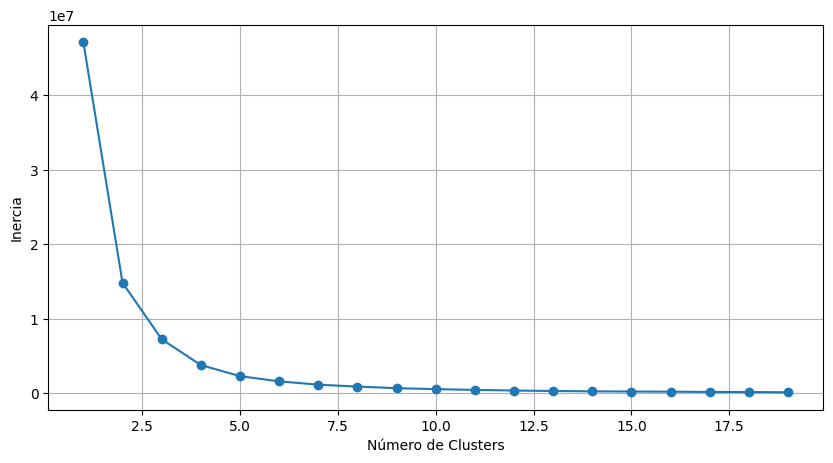

In [46]:
optimizacion_cluster(ccdf[["Median", "Amount"]], 20)

Viendo la gráfica observamos que la inercia (la suma de las distancias al centro del cluster más cercano elevada al cuadrado) decrece a medida que vamos aumentando en número de clusters. También se puede apreciar que hay un gran cambio a partir del cluster 2 en adelante.

### Aplicando el algoritmo

Vamos a comparar diferentes usos de KMeans para poder decidir mejor con qué número de clusters nos interesa quedarnos.

Este bucle lo que hace es aplicar el algoritmo 10 veces (número elegido fijándonos en la gráfica anterior ya que a partir del 10 se estabiliza la inercia) y añadir una columna a nuestro Dataframe con la información de a qué grupo pertenece cada fila por cada aplicación del algoritmo. El objetivo de esto es poder visualizar las agrupaciones mediante gráficas y poder así tomar una decisión final sobre que número de clusters nos conviene más.

In [47]:
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, n_init=10)
  kmeans.fit(ccdf[['Median', 'Amount']])
  ccdf[f'KMeans_{i}'] = kmeans.labels_

In [48]:
ccdf

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5,KMeans_6,KMeans_7,KMeans_8,KMeans_9,KMeans_10
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0,0,0,0,0,0,1,2,3,0
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0,1,1,1,2,2,0,3,2,5
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,0,0,0,2,2,2,3,6,7,2
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0,0,0,0,0,0,1,2,0,7
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0,0,0,0,0,0,1,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,83649.0,-0.416094,0.946972,1.535867,-0.017599,-0.197070,-0.927376,0.621247,0.008576,-0.194193,...,0,0,0,0,0,0,1,2,3,0
980,144298.0,-0.314848,-0.491023,0.043379,-1.172094,2.630379,3.970517,-0.498038,0.933081,0.573519,...,0,0,0,0,0,0,1,2,3,7
981,55086.0,1.073135,-1.304944,1.046033,-0.468642,-1.497430,0.678596,-1.082262,0.314917,0.125745,...,0,0,0,0,4,4,5,0,0,4
982,43757.0,1.333519,-1.091836,0.322732,-1.434698,-1.313434,-0.512193,-0.803751,-0.018318,-2.280847,...,0,0,0,0,0,0,1,2,0,7


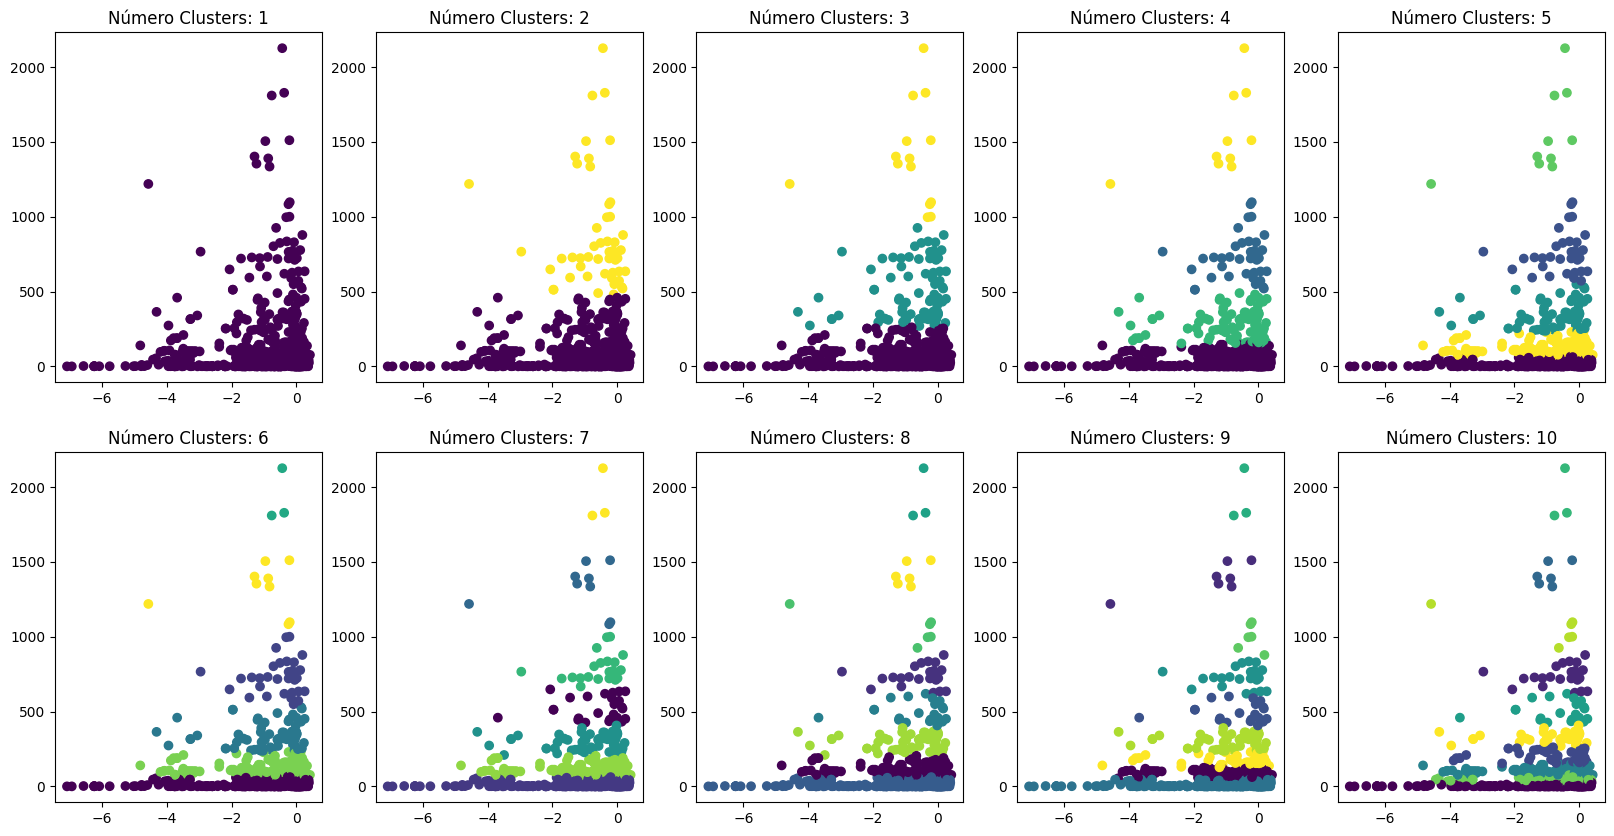

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for i, ax in enumerate(fig.axes, start=1):
  ax.scatter(x=ccdf['Median'], y=ccdf['Amount'], c=ccdf[f'KMeans_{i}'])
  ax.set_title(f'Número Clusters: {i}')

Observando esta comparativa llegamos a la conclusión de que el valor que más nos interesa es el de 5 clusters.

### Limpieza del Dataframe

Ahora vamos a limpiar el Dataframe de todas las columnas que no vamos a necesitar.

In [50]:
ccdf.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Median', 'KMeans_1', 'KMeans_2', 'KMeans_3', 'KMeans_4',
       'KMeans_5', 'KMeans_6', 'KMeans_7', 'KMeans_8', 'KMeans_9',
       'KMeans_10'],
      dtype='object')

In [51]:
drp_clmns = ['KMeans_1', 'KMeans_2', 'KMeans_3', 'KMeans_4',
             'KMeans_5', 'KMeans_6', 'KMeans_7', 'KMeans_8',
             'KMeans_9', 'KMeans_10']

In [52]:
ccdf.drop(columns=drp_clmns, inplace=True)

In [53]:
ccdf

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Median
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,-0.484571
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,0.148612
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,-0.755080
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,-1.866638
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,0.194415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,83649.0,-0.416094,0.946972,1.535867,-0.017599,-0.197070,-0.927376,0.621247,0.008576,-0.194193,...,-0.703787,-0.002073,0.329566,-0.238724,0.075579,0.256035,0.118243,4.49,0,-0.029101
980,144298.0,-0.314848,-0.491023,0.043379,-1.172094,2.630379,3.970517,-0.498038,0.933081,0.573519,...,0.976457,0.028608,0.753327,-0.691489,0.201007,0.063510,-0.008396,44.22,0,0.286308
981,55086.0,1.073135,-1.304944,1.046033,-0.468642,-1.497430,0.678596,-1.082262,0.314917,0.125745,...,-1.408882,0.159184,0.079570,-0.107194,1.197509,-0.031223,0.010779,90.00,0,-0.140589
982,43757.0,1.333519,-1.091836,0.322732,-1.434698,-1.313434,-0.512193,-0.803751,-0.018318,-2.280847,...,-1.356493,0.296495,0.120024,-0.076515,-0.645358,0.018647,0.020566,62.01,0,-0.198718


### Aplicando el algoritmo final

In [54]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(ccdf[['Median', 'Amount']])
ccdf[f'KMeans_{5}'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
ccdf

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Median,KMeans_5
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,-0.484571,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,0.148612,2
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,-0.755080,2
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,-1.866638,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,0.194415,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,83649.0,-0.416094,0.946972,1.535867,-0.017599,-0.197070,-0.927376,0.621247,0.008576,-0.194193,...,-0.002073,0.329566,-0.238724,0.075579,0.256035,0.118243,4.49,0,-0.029101,1
980,144298.0,-0.314848,-0.491023,0.043379,-1.172094,2.630379,3.970517,-0.498038,0.933081,0.573519,...,0.028608,0.753327,-0.691489,0.201007,0.063510,-0.008396,44.22,0,0.286308,1
981,55086.0,1.073135,-1.304944,1.046033,-0.468642,-1.497430,0.678596,-1.082262,0.314917,0.125745,...,0.159184,0.079570,-0.107194,1.197509,-0.031223,0.010779,90.00,0,-0.140589,3
982,43757.0,1.333519,-1.091836,0.322732,-1.434698,-1.313434,-0.512193,-0.803751,-0.018318,-2.280847,...,0.296495,0.120024,-0.076515,-0.645358,0.018647,0.020566,62.01,0,-0.198718,1


### Estudio de los grupos

Tras una escueta investigación hemos asignado los siguientes valores a cada cluster para poder entender mejor la situación de cada uno:

* 0: Desarrollo Personal (Personal Growht)
* 1: Ocio (Leisure)
* 2: Necesidades Básicas (Basic Necessities)
* 3: Préstamos (Loans)
* 4: Inversiones (Investments)

## Generación de los archivos .pkl

In [56]:
dump(model, 'modelo_fraud_detect.pkl')

['modelo_fraud_detect.pkl']

In [57]:
dump(kmeans, 'clustering_fraud_detect.pkl')

['clustering_fraud_detect.pkl']